# Case study of plane-strain compression tests


In [1]:
import copy

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import paramaterial as pam
from paramaterial.plug import DataSet, DataItem

## Data preparation


1. Create two directories: "data", "info".
2. Save all csv files into a directory called "data/01 raw data".
3. Make a corresponding info table, where the first column is a unique test id.
4. Make a backup.
5. Rename the files according to the test id.

Copy raw data and info into backup, incase raw data becomes damaged during processing.

In [2]:
pam.preparing.copy_data_and_info(old_data_dir='data/01 raw data', new_data_dir='data/00 backup data',
                                 old_info_path='info/01 raw info.xlsx', new_info_path='info/00 backup info.xlsx')

Copied 40 files from data/01 raw data to data/00 backup data.
Copied info table from info/01 raw info.xlsx to info/00 backup info.xlsx.


Rename files according to test id.

In [3]:
# pam.preparing.rename_by_test_id('data/01 raw data', 'info/01 raw info.xlsx')

Check that column headers of data files are all the same. If not the same, fix.

In [4]:
# pam.preparing.check_column_headers('data/01 raw data')

In [5]:
raw_set = DataSet('data/01 raw data', 'info/01 raw info.xlsx')

### Dataset EDA

Number of unique values in categorical info columns.

In [6]:
raw_set.info_table.nunique()

test id         40
old filename    40
test type        2
material         1
rate             3
temperature      3
b_0 (mm)         2
b_f (mm)        31
L_0 (mm)         1
h_0 (mm)         2
w_0 (mm)         2
Ascale           2
Bscale           2
dtype: int64

Experimental matrix.

In [7]:
index = ['test type', 'rate']
columns = ['temperature']
raw_set.info_table.groupby(index + columns).size().unstack(columns).fillna(0).astype(int)

temperature     300  350  400
test type rate               
PSC       10      7    1    2
          30      2    2    2
          100     2    0    2
PSC*      10      2    2    2
          30      2    2    2
          100     2    4    2

Plot of the dataset.

<AxesSubplot:xlabel='Strain'>

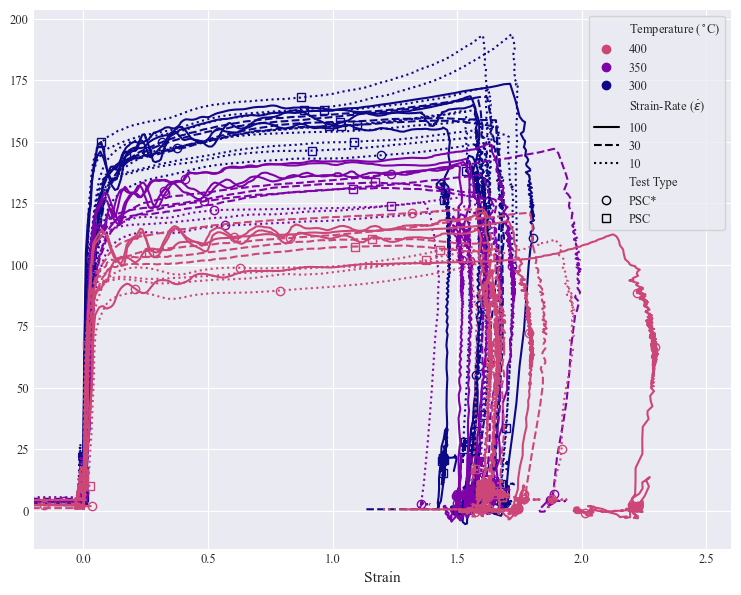

In [8]:
raw_set = raw_set.sort_by(['rate', 'temperature'], ascending=False)

styler = pam.plotting.Styler(
    linestyle_by='rate', linestyle_by_label=r'Strain-Rate ($\dot{\varepsilon}$)',
    color_by='temperature', color_by_label=r'Temperature ($^{\circ}$C)',
    marker_by='test type', marker_by_label='Test Type', color_norm=plt.Normalize(300, 500),
    plot_kwargs={'xlim':(-0.2, 2.6), 'grid':True, 'figsize':(9, 7), 'markevery':0.7, 'mfc':'none'}
).style_to(raw_set)


def ds_plot(_ds, **kwargs):
    return pam.plotting.dataset_plot(_ds, styler=styler, **kwargs)


ds_plot(raw_set, x='Strain', y='Stress(MPa)')

array([[<AxesSubplot:title={'center':'10 s$^{-1}$'}, xlabel='Strain'>,
        <AxesSubplot:title={'center':'30 s$^{-1}$'}, xlabel='Strain'>,
        <AxesSubplot:title={'center':'100 s$^{-1}$'}, xlabel='Strain'>],
       [<AxesSubplot:xlabel='Strain'>, <AxesSubplot:xlabel='Strain'>,
        <AxesSubplot:xlabel='Strain'>]], dtype=object)

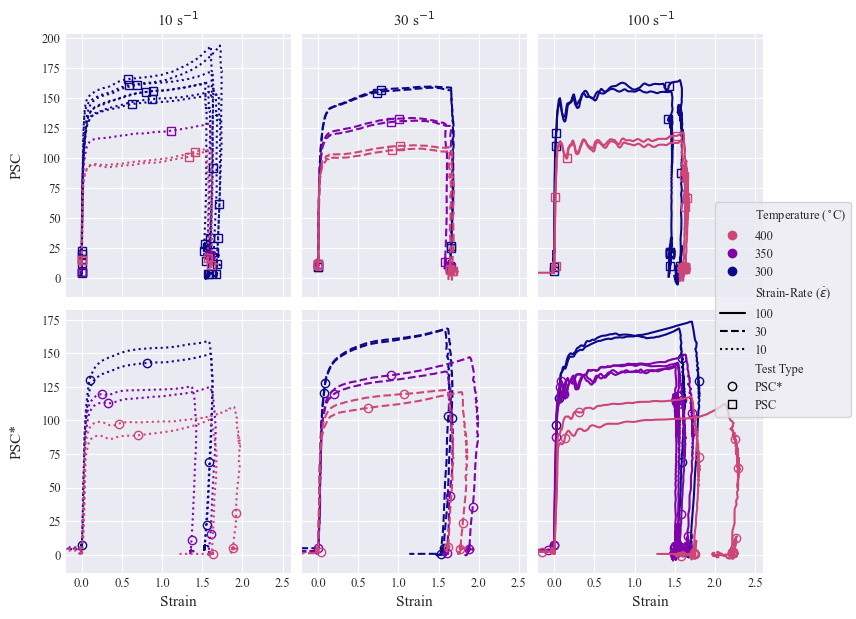

In [9]:
def ds_subplot(ds: DataSet, **kwargs):
    axs = pam.plotting.subplot_wrapper(
        ds, ds_plot, styler_legend=False, legend=False,
        shape=(2, 3), wspace=0.05, hspace=0.05, figsize=(10, 7),
        rows_by='test type', cols_by='rate',
        row_vals=[['PSC'], ['PSC*']], col_vals=[[10], [30], [100]],
        row_titles=['PSC', 'PSC*'], col_titles=['10 s$^{-1}$', '30 s$^{-1}$', '100 s$^{-1}$'],
        **kwargs
    )
    axs.flat[0].get_figure().legend(handles=styler.legend_handles(), loc='right', frameon=True)
    return axs


ds_subplot(raw_set, x='Strain', y='Stress(MPa)')

## Processing
We now want to:
- Trim the data
- Apply friction corrections
- Make representative curves
- Screen the data

### Trimming the data
- Remove unnecessary columns
- Trim leading and trailing data using time-step change
- Trim remaining trailing data after max force

In [10]:
raw_set[0].data.columns

Index(['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'PTemp', 'Strain',
       'Stress(MPa)', 'TC1(C)', 'TC2(C)', 'TC3(C)', 'TC4(C)'],
      dtype='object')

In [11]:
def drop_columns(di: DataItem) -> DataItem:
    di.data = di.data.drop(columns=['PowAngle(deg)', 'PTemp'])
    return di


raw_set = raw_set.apply_function(drop_columns)

#### Trim using sampling rate change
After calculating the time-steps, we remove data that was sampled with a larger time-step.

<AxesSubplot:>

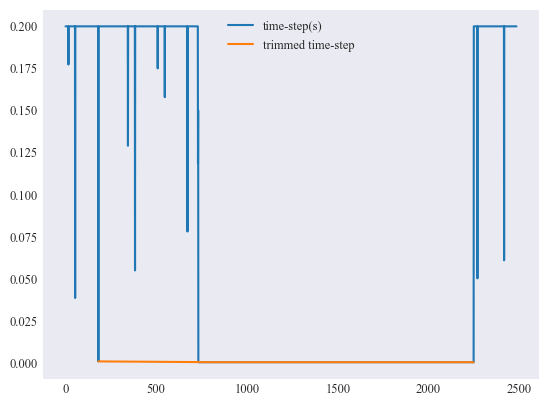

In [12]:
# calculate time-step
raw_item = raw_set[0]
time_step = np.diff(raw_item.data['Time(sec)'])
raw_item.data['time-step(s)'] = np.hstack([time_step[0], time_step])
ax = raw_item.data.plot(y='time-step(s)')

# trim by time-step
raw_item.data = raw_item.data[raw_item.data['time-step(s)'] < 0.02]
raw_item.data.plot(ax=ax, y='time-step(s)', label='trimmed time-step')

Trim dataset using time-step change. Notice how the data around origin has been cleaned. Use the subplot to check that no data in the main part of the curve was lost.

array([[<AxesSubplot:title={'center':'10 s$^{-1}$'}, xlabel='Strain'>,
        <AxesSubplot:title={'center':'30 s$^{-1}$'}, xlabel='Strain'>,
        <AxesSubplot:title={'center':'100 s$^{-1}$'}, xlabel='Strain'>],
       [<AxesSubplot:xlabel='Strain'>, <AxesSubplot:xlabel='Strain'>,
        <AxesSubplot:xlabel='Strain'>]], dtype=object)

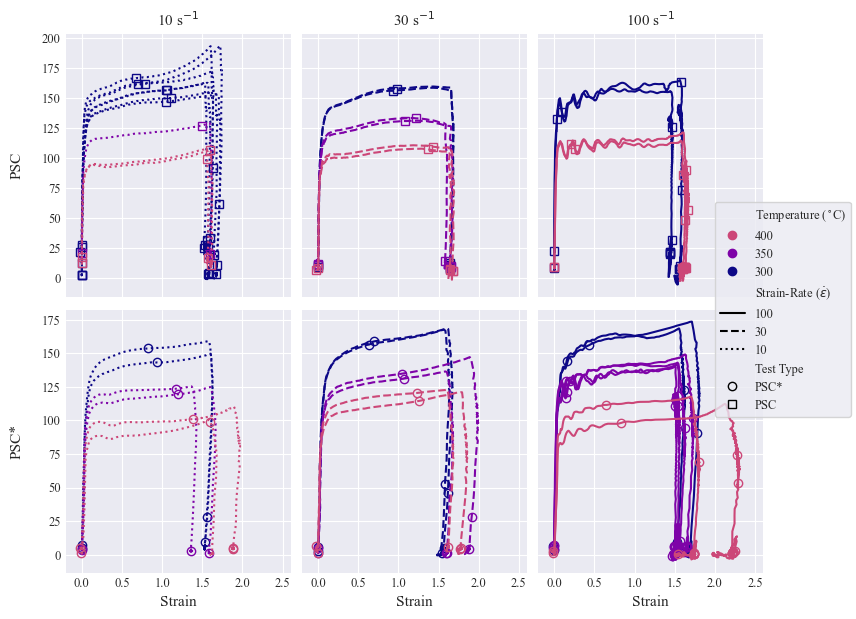

In [13]:
def trim_using_time_step_change(di: DataItem) -> DataItem:
    t_diff = np.diff(di.data['Time(sec)'])
    di.data['time diff'] = np.hstack([t_diff[0], t_diff])
    di.data = di.data[di.data['time diff'] < 0.02]
    return di


trim1_set = raw_set.apply_function(trim_using_time_step_change)

ds_subplot(trim1_set, x='Strain', y='Stress(MPa)')

#### Trim using max force
The end of a compression test can be identified my the maximum force.

<AxesSubplot:xlabel='Strain'>

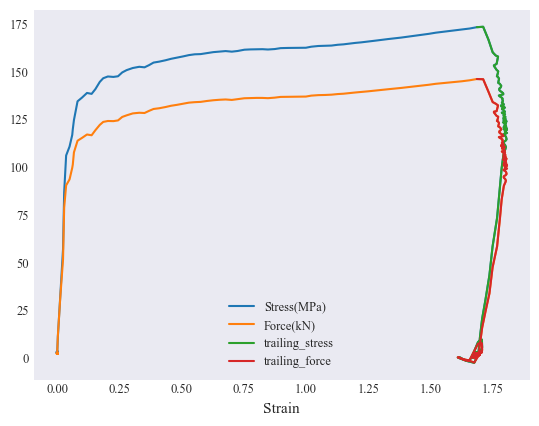

In [14]:
# investigate using max force index for trimming stress
raw_item = trim1_set[0]

max_force_index = raw_item.data['Force(kN)'].idxmax()
trailing_data = raw_item.data.iloc[max_force_index:].copy()
trailing_data[['trailing_stress', 'trailing_force']] = trailing_data[['Stress(MPa)', 'Force(kN)']]
trailing_data['trailing_force'] = trailing_data['Force(kN)']

ax = raw_item.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])
trailing_data.plot(ax=ax, x='Strain', y=['trailing_stress', 'trailing_force'])

<AxesSubplot:xlabel='Strain'>

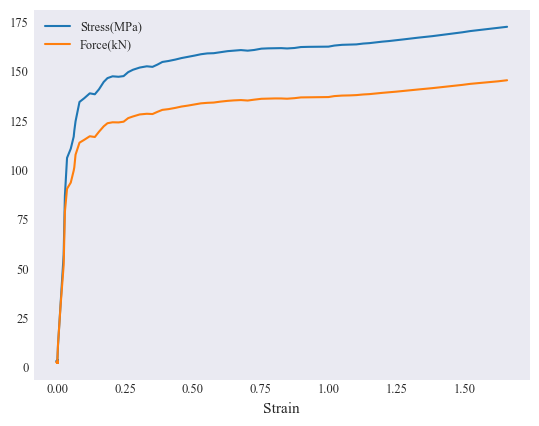

In [15]:
# demonstrate max force trimming for one dataitem
def remove_trailing_data(di: DataItem):
    di.data = di.data.iloc[:di.data['Force(kN)'].idxmax()]
    return di


trimmed_dataitem = remove_trailing_data(raw_item)
trimmed_dataitem.data.plot(x='Strain', y=['Stress(MPa)', 'Force(kN)'])

Trim dataset using max force. This trimming procedure hasn't worked as well as it did for the uniaxial compression tests. Here, some tests are trimmed prematurely.

array([[<AxesSubplot:title={'center':'10 s$^{-1}$'}, xlabel='Strain'>,
        <AxesSubplot:title={'center':'30 s$^{-1}$'}, xlabel='Strain'>,
        <AxesSubplot:title={'center':'100 s$^{-1}$'}, xlabel='Strain'>],
       [<AxesSubplot:xlabel='Strain'>, <AxesSubplot:xlabel='Strain'>,
        <AxesSubplot:xlabel='Strain'>]], dtype=object)

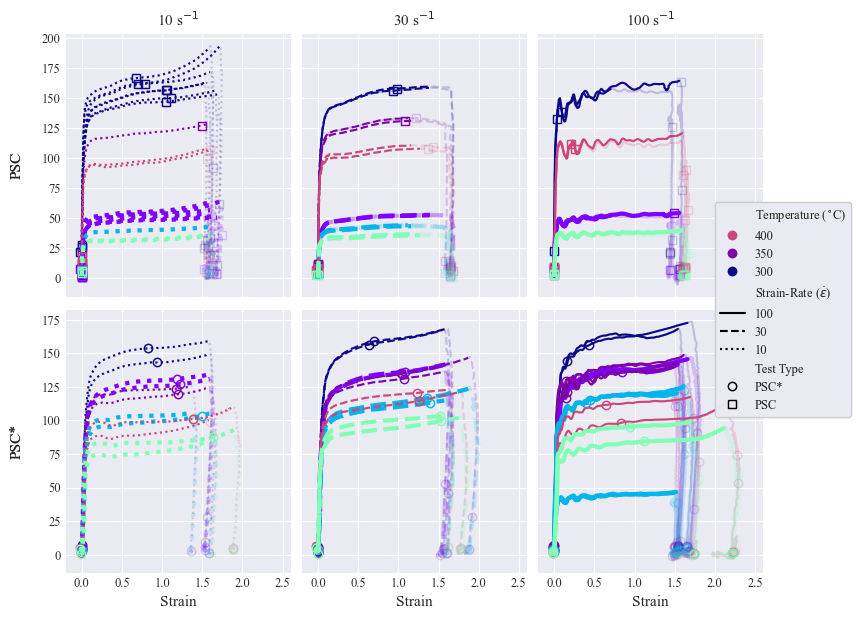

In [16]:
styler.cmap = 'plasma'
axs = ds_subplot(trim1_set, x='Strain', y='Stress(MPa)', alpha=0.2)
trim2_set = trim1_set.apply_function(remove_trailing_data)
axs = ds_subplot(trim2_set, x='Strain', y='Stress(MPa)', axs=axs)

styler.cmap = 'rainbow'


def force_plot(ds, **kwargs):
    return pam.plotting.dataset_subplots(
        ds, legend=False, styler_legend=False, x='Strain', y='Force(kN)',
        styler=styler, shape=(2, 3), mfc='none', markevery=0.7,
        rows_by='test type', cols_by='rate', linewidth=3,
        row_vals=[['PSC'], ['PSC*']], col_vals=[[10], [30], [100]], **kwargs)


axs = force_plot(trim1_set, alpha=0.2, axs=axs)
force_plot(trim2_set, axs=axs)

Looks like we have a PSC S100 test mislabeled as a PSC* test.

Save trimmed data.

In [17]:
trim2_set.write_output('data/02 trimmed data', 'info/02 trimmed info.xlsx')

### Screening

### Screening
1. Make a screening pdf from the trimmed data.
2. Mark the pdf.
3. Run screening using the marked pdf to discard unwanted items.

Make a plot for the screening pdf. Test it on a dataitem. Make the screening pdf.

0DataItems [00:00, ?DataItems/s]    
0DataItems [00:00, ?DataItems/s]
3DataItems [00:00, 27.74DataItems/s]
7DataItems [00:00, 31.76DataItems/s]
                                    
0DataItems [00:00, ?DataItems/s]
7DataItems [00:00, 60.16DataItems/s]
                                    
0DataItems [00:00, ?DataItems/s]
3DataItems [00:00, 26.88DataItems/s]
6DataItems [00:00, 28.22DataItems/s]
                                    
0DataItems [00:00, ?DataItems/s]
4DataItems [00:00, 36.53DataItems/s]
8DataItems [00:00, 36.90DataItems/s]
1DataItems [00:04,  4.02s/DataItems]
0DataItems [00:00, ?DataItems/s]
4DataItems [00:00, 35.45DataItems/s]
8DataItems [00:00, 34.87DataItems/s]
                                    
0DataItems [00:00, ?DataItems/s]
3DataItems [00:00, 29.08DataItems/s]
                                    
0DataItems [00:00, ?DataItems/s]
4DataItems [00:00, 34.62DataItems/s]
8DataItems [00:00, 22.96DataItems/s]
                                    
0DataItems [00:00, ?DataItems

Screening pdf saved to data/02 trimmed data screening_2.pdf.


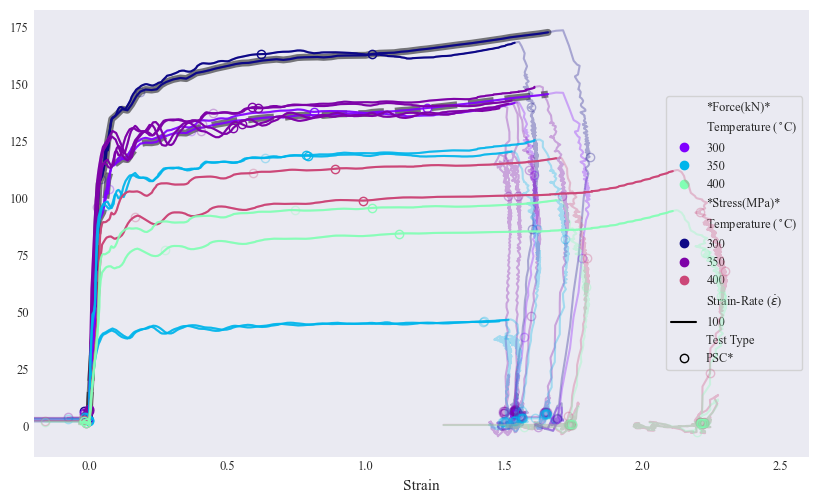

In [25]:
from matplotlib.patches import Patch

raw_set = DataSet('data/01 raw data', 'info/01 raw info.xlsx')
trim_set = DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx')


def screening_plot(di: DataItem) -> None:
    """Screening plot function."""
    subset = {'test type': [di.info['test type']], 'rate': [di.info['rate']]}
    styler.plot_kwargs.update({'figsize': (10,5.8)})

    styler.cmap = 'plasma'
    _ax = ds_plot(raw_set[subset], x='Strain', y='Stress(MPa)', alpha=0.3)
    _ax = ds_plot(trim_set[subset], x='Strain', y='Stress(MPa)', ax=_ax)

    stress_handles = styler.legend_handles(raw_set[subset])

    styler.cmap = 'rainbow'
    _ax = ds_plot(raw_set[subset], x='Strain', y='Force(kN)', alpha=0.3, ax=_ax)
    _ax = ds_plot(trim_set[subset], x='Strain', y='Force(kN)', alpha=0.9, ax=_ax)

    st = copy.deepcopy(styler)
    st.linestyle_by, st.linestyle_by_label = None, None
    st.marker_by, st.marker_by_label = None, None
    force_handles = st.legend_handles(trim_set[subset])

    _ax = di.data.plot(x='Strain', y='Stress(MPa)', color='k', ax=_ax, lw=5, alpha=0.5)
    _ax = di.data.plot(x='Strain', y='Force(kN)', c='k', ls='--', ax=_ax, lw=5, alpha=0.5)

    plt.legend(loc='right', frameon=True, handles=[Patch(label='*Force(kN)*', alpha=0)] + force_handles
                                    + [Patch(label='*Stress(MPa)*', alpha=0)] + stress_handles)


# test screening plot
screening_plot(trim_set[0])
# make pdf
pam.processing.make_screening_pdf(trim_set, screening_plot, 'data/02 trimmed data screening.pdf')

Delete the rejected data. Once this has been done, re-make the representative data.

In [19]:
trim_set = DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx')
pam.processing.screen_data(trim_set, 'data/screened/02 trimmed data screening marked 21Oct18h57.pdf',
                           'data/screened/02 trim screen data', 'info/screened/02 trim screen info.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'data/screened/02 trimmed data screening marked 21Oct18h57.pdf'

In [ ]:
trim_screen_set = DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx')
trim_screen_set.info_table['comment'].dropna()

Process based on screening comments.

In [ ]:
def screening_comment_function(di: DataItem) -> DataItem:
    if str(di.info['comment']).startswith('trim at'):
        trim_strain = di.info['comment'].split(' ')[2]
        di.data = di.data[di.data['Strain'] <= float(trim_strain)]
        print(f'Trimming {di.test_id} at {trim_strain} strain.')
        return di
    else:
        return di


comment_fixed_set = trim_screen_set.map_function(screening_comment_function)
comment_fixed_set.write_output('data/04 screened trimmed data', 'info/04 screened trimmed info.xlsx')

### Applying the friction correction.
$$
\sigma = P \left[\frac{h}{\mu d} \right]^{-2}\left[\exp\left(\frac{\mu d}{h}\right) - \frac{\mu d}{h} - 1 \right]^{-1}
$$

Demonstrate friction correction for one dataitem

In [ ]:
# uncorr_item = DataSet
#
# # apply friction correction function to dataset
# def friction_correction(di: DataItem) -> DataItem:
#     mu = 0.3  # friction coefficient
#     h_0 = di.info['L_0']  # initial height in axial direction
#     d_0 = di.info['D_0']  # initial diameter
#     h = h_0 - di.data['Jaw(mm)']  # instantaneous height
#     d = d_0*np.sqrt(h_0/h)  # instantaneous diameter
#     P = di.data['Force(kN)']*1000*4/(np.pi*d ** 2)  # pressure (MPa)
#     di.data['Pressure(MPa)'] = P
#     di.data['raw stress'] = di.data['Stress(MPa)']
#     di.data['Stress(MPa)'] = P/(1 + (mu*d)/(3*h))  # correct stress
#     return di
#
# corr_item = friction_correction(uncorr_item)
# corr_item.data.plot(x='Strain', y=['raw stress', 'Stress(MPa)'])

Apply friction correction to dataset.

In [ ]:
# corr_set = trim_set.map_function(friction_correction)

Compare corrected to un-corrected for a subset

In [ ]:
# subset_filter = {'material': ['H560'], 'rate': [1], 'temperature': [400, 500]}
# ax = ds_plot(trim_set[subset_filter], alpha=0.3)
# fig = ax.get_figure()
# fig.delaxes(fig.axes[1])
# ds_plot(corr_set[subset_filter], ax=ax)

In [ ]:
# fig, axs = ds_subplot(trim_set, alpha=0.3, linestyle=':')
# ds_subplot(corr_set, fig=fig, axs=axs)
# ax = ds_plot(corr_set, alpha=0.8)
# ds_plot(trim_set, ax=ax, alpha=0.3)

### Write corrected data to new folder

In [ ]:
# corr_set = DataSet('data/03 corrected data', 'info/03 corrected info.xlsx')
# pam.processing.screen_data(corr_set, 'data/screened/02 trimmed data screening marked 21Oct18h57.pdf',
#                            'data/screened/03 corr screen data', 'info/screened/03 corr screen info.xlsx')

In [ ]:
corr_set.write_output('data/03 corrected data', 'info/03 corrected info.xlsx')

### Make representative curves

In [ ]:
pam.processing.make_representative_curves(DataSet('data/02 trimmed data', 'info/02 trimmed info.xlsx'),
                                          'data/02 repr trim data', 'info/02 repr trim info.xlsx',
                                          repr_col='Stress(MPa)', repr_by_cols=['temperature', 'material', 'rate'],
                                          interp_by='Strain')

In [ ]:
def repr_ds_subplot(dataset: DataSet):
    return pam.plotting.dataset_subplots(
        dataset, x='interp_Strain', y='mean_Stress(MPa)', ylabel='Stress (MPa)',
        shape=(3, 4), rows_by='material', cols_by='rate',
        row_vals=[['AC'], ['H560'], ['H580']], col_vals=[[1], [10], [50], [100]],
        row_titles=['AC', 'H560', 'H580'], col_titles=['1 s$^{-1}$', '10 s$^{-1}$', '50 s$^{-1}$', '100 s$^{-1}$'],
        color_by='temperature', cbar=True, cbar_label='Temperature ($^{\circ}$C)',
        xlim=(-0.2, 1.8), grid=True, wspace=0.05, hspace=0.05,
        fill_between=('down_std_Stress(MPa)', 'up_std_Stress(MPa)')
    )


repr_ds_subplot(DataSet('data/02 repr trim data', 'info/02 repr trim info.xlsx', test_id_key='repr id'))

In [ ]:
# pam.processing.make_representative_curves(DataSet('data/03 corrected data', 'info/03 corrected info.xlsx'),
#                                           'data/03 repr corr data', 'info/03 repr corr info.xlsx',
#                                           repr_col='Stress(MPa)', repr_by_cols=['temperature', 'material', 'rate'],
#                                           interp_by='Strain')

In [ ]:
# repr_ds_subplot(DataSet('data/03 repr corr data', 'info/03 repr corr info.xlsx', test_id_key='repr id'))

## Modelling
1. Identify points of interest algorithmically
2. Fit material model

### Reference results
This table of results was produced in a separate analysis. It is unclear at what strain the mean temperature and flow stress were determined. We will try at 0.1 strain and at 0.3 strain.

In [ ]:
reference_table = pd.read_excel('report/baron quoted results.xlsx')
reference_table = reference_table.rename(columns={
    'Strain-rate (s^-1)': 'rate', 'Nominal temperature': 'temperature', 'Material condition': 'material',
    'Mean temperature': 'mean temperature', 'Mean flow stress (MPa)': 'mean flow stress'
})
reference_table = reference_table.set_index(['material', 'rate', 'temperature']).sort_index().reset_index()
reference_table

### Analysis results
We want to repeat the analysis using Paramaterial and compare results.
The following steps are required:
1. Get the relevant subset
2. Apply function to read temperature and flow stress at 0.1 and 0.3 strain
3. Performing averaging
4. Compare results

Run analysis.

In [ ]:
analysis_set = DataSet('data/04 screened trimmed data', 'info/04 screened trimmed info.xlsx')[{'rate': [1, 10]}]


def read_temp_and_stress(di: DataItem) -> DataItem:
    # interpolate the temperature and stress at 0.1 strain and 0.3 strain
    di.info['0.1 temperature'] = np.interp(0.1, di.data['Strain'], di.data['TC1(C)'])
    di.info['0.3 temperature'] = np.interp(0.3, di.data['Strain'], di.data['TC1(C)'])
    di.info['0.1 stress'] = np.interp(0.1, di.data['Strain'], di.data['Stress(MPa)'])
    di.info['0.3 stress'] = np.interp(0.3, di.data['Strain'], di.data['Stress(MPa)'])
    return di


analysis_set = analysis_set.apply_function(read_temp_and_stress)
analysis_set.info_table.head()

Check for outliers.

In [ ]:
analysis_table = analysis_set.info_table[
    ['test id', 'material', 'temperature', 'rate', '0.1 temperature', '0.3 temperature', '0.1 stress', '0.3 stress']]
analysis_table.boxplot(by='material', column=['0.1 temperature', '0.3 temperature', '0.1 stress', '0.3 stress'])

In [ ]:
analysis_table = analysis_table.groupby(['material', 'temperature', 'rate']).mean().reset_index()
analysis_table

Investigate outlier.

In [ ]:
analysis_table[analysis_table['0.3 temperature'] > 1000]

In [ ]:
analysis_set[11].data.plot(x='Strain', y=['Stress(MPa)', 'TC1(C)'])

Remove outlier.

In [ ]:
analysis_table = analysis_table[analysis_table['0.3 temperature'] < 1000]
analysis_table.boxplot(by='material', column=['0.1 temperature', '0.3 temperature', '0.1 stress', '0.3 stress'])

### Compare reference and analysis
Combine reference results and analysis for comparison.

In [ ]:
# analysis_table.drop(columns=['test id'], inplace=True)
merged_table = pd.merge(reference_table, analysis_table, on=['material', 'rate', 'temperature'])
merged_table

In [ ]:
melt_df = pd.melt(merged_table, id_vars=['material', 'rate', 'temperature'],
                  value_vars=['mean temperature', '0.1 temperature', '0.3 temperature', 'mean flow stress',
                              '0.1 stress', '0.3 stress'])

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row')

columns = [['mean temperature', '0.1 temperature'], ['mean temperature', '0.3 temperature'],
           ['mean flow stress', '0.1 stress'], ['mean flow stress', '0.3 stress']]

for ax, cols in zip(axs.flat, columns):
    sns.violinplot(x='material', y='value', hue='variable', split=True,
                   ax=ax, data=melt_df[melt_df['variable'].isin(cols)])
    ax.legend(frameon=True)

Based on the violin plots, it looks like the 0.3 stress and temperature match the reference mean. We can confirm this using regression.

### Reference model

### Analysis model

### Model comparison